# **Waste Material Segregation for Improving Waste Management by Sumanth Bharadwaj Prasannakumar**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

In [4]:
# Only relevant if running in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Only relevant if running in google colab
import zipfile

# Load and unzip the dataset
zip_path = '/content/drive/MyDrive/CNN-WasteSegregationAssignment/data.zip'
extract_dir ='/content/drive/MyDrive/CNN-WasteSegregationAssignment/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

**Import Necessary Libraries**

In [12]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [6]:
# Import essential libraries
!pip install tensorflow==2.18.0
!pip install keras==3.8.0

from skimage import io
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow
import keras
from PIL import Image

In [7]:
import seaborn as sns

Load the dataset.

*(Note - The actual load of dataset is carried out below in next sub section using `keras.utils.image_dataset_from_directory`)*

In [8]:
BASE_DIR = extract_dir + "data"

In [9]:
def get_image_dimensions(directory):
    '''
    The function to list the width and height of the images.
    This is used to calculate the min/max width and height out of all the images
    '''
    widths = []
    heights = []

    for root, _, files in os.walk(directory):
        for file in files:
            try:
                filepath = os.path.join(root, file)
                with Image.open(filepath) as img:
                    width, height = img.size
                    widths.append(width)
                    heights.append(height)
            except:
                continue  # Skip non-image files

    return widths, heights

In [10]:
widths_list, heights_list = get_image_dimensions(BASE_DIR)

In [11]:
min_widths_list, max_widths_list = min(widths_list), max(widths_list)
min_widths_list, max_widths_list

(256, 256)

In [12]:
min_heights_list, max_heights_list = min(heights_list), max(heights_list)
min_heights_list, max_heights_list

(256, 256)

#### All images are 256 X 256 size. Hence Not going to reshape it as of now.

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [13]:
# Create a function to load the raw images
# This function takes terraform iterator as an input

def load_images(tf_input_dataset):
    '''
    This function takes terraform iterator as an input
    and loads all the images into memory using the tf_input_dataset.unbatch()

    It returns the images and labels as numpy arrays
    '''
    all_images = []
    all_labels = []
    for images, labels in tf_input_dataset.unbatch():
        all_images.append(images.numpy())
        all_labels.append(labels.numpy())
    all_images = np.stack(all_images)
    all_labels = np.stack(all_labels)
    return all_images, all_labels

#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [14]:
# Parameters to load images
batch_size = 32
image_size = (max_heights_list, max_widths_list)
validation_split=0.2 # The train:test split
interpolation = "bilinear" # Not relevant for now but still making the default value explicit

In [15]:
# Create a function to load the raw images
tf_train_dataset, tf_val_dataset = keras.utils.image_dataset_from_directory(
    directory=BASE_DIR,
    labels="inferred",
    # label_mode='categorical',
    # commenting this out to say that we dont need to perform one-hot encoding explicitly
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    seed=123,
    interpolation=interpolation,
    pad_to_aspect_ratio=True,
    subset="both")


Found 7625 files belonging to 7 classes.
Using 6100 files for training.
Using 1525 files for validation.


In [16]:
# Get the images and their labels

# Load entire images and labels into memory
train_images, train_labels = load_images(tf_train_dataset)

val_images, val_labels = load_images(tf_val_dataset)

In [17]:
print(f"loaded train dataset - {len(train_images)} images of shape {train_images.shape} and {len(train_labels)} labels of shape {train_labels.shape}")
print(f"loaded validation dataset -  {len(val_images)} images of shape {val_images.shape} and {len(val_labels)} labels of shape {val_labels.shape}")

loaded train dataset - 6100 images of shape (6100, 256, 256, 3) and 6100 labels of shape (6100,)
loaded validation dataset -  1525 images of shape (1525, 256, 256, 3) and 1525 labels of shape (1525,)


*(Note - we can think about splitting the data to tackle class imbalance as well)*

Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

In [18]:
def bar_plot_categories(labels, class_names, plt_name):
    '''
    This function creates a bar plot to display the class distribution
    '''
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title(plt_name)
    ax = sns.countplot(x=labels[0:], legend="full", orient=45)
    ax.tick_params(axis="x")
    ax.set_xticklabels(class_names, rotation=45)
    for c in ax.containers:
        ax.bar_label(c)

<ipython-input-18-f2ecd55e72e0>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=45)


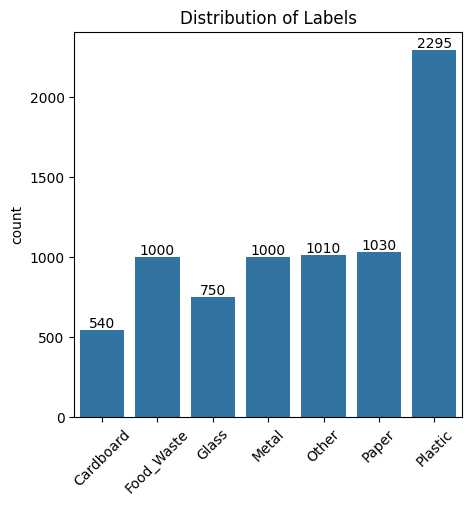

In [19]:
# Visualise Data Distribution
# Total Label distribution = training labels + validation labels
labels = np.concatenate((train_labels, val_labels), axis=0)

bar_plot_categories(labels, tf_train_dataset.class_names, "Distribution of Labels")

<ipython-input-18-f2ecd55e72e0>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=45)


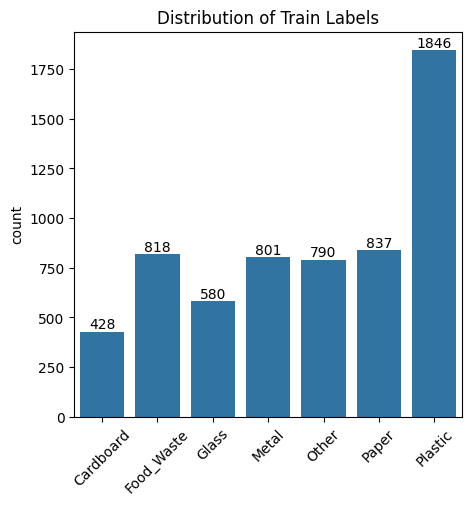

In [20]:
bar_plot_categories(train_labels, tf_train_dataset.class_names, "Distribution of Train Labels")

<ipython-input-18-f2ecd55e72e0>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(class_names, rotation=45)


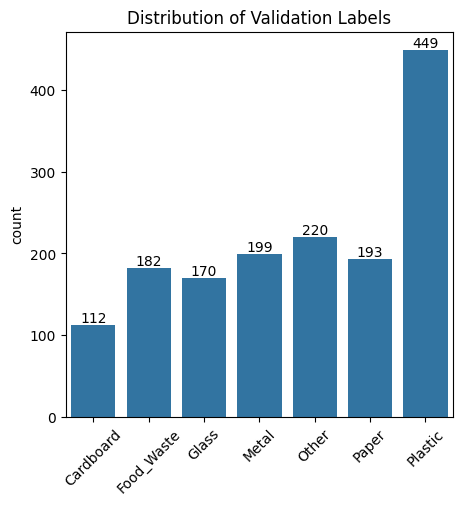

In [21]:
bar_plot_categories(val_labels, tf_val_dataset.class_names, "Distribution of Validation Labels")

#### *Plastic category has more images*
But the categorical variables' split is more or less similar in both train and validation dataset

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

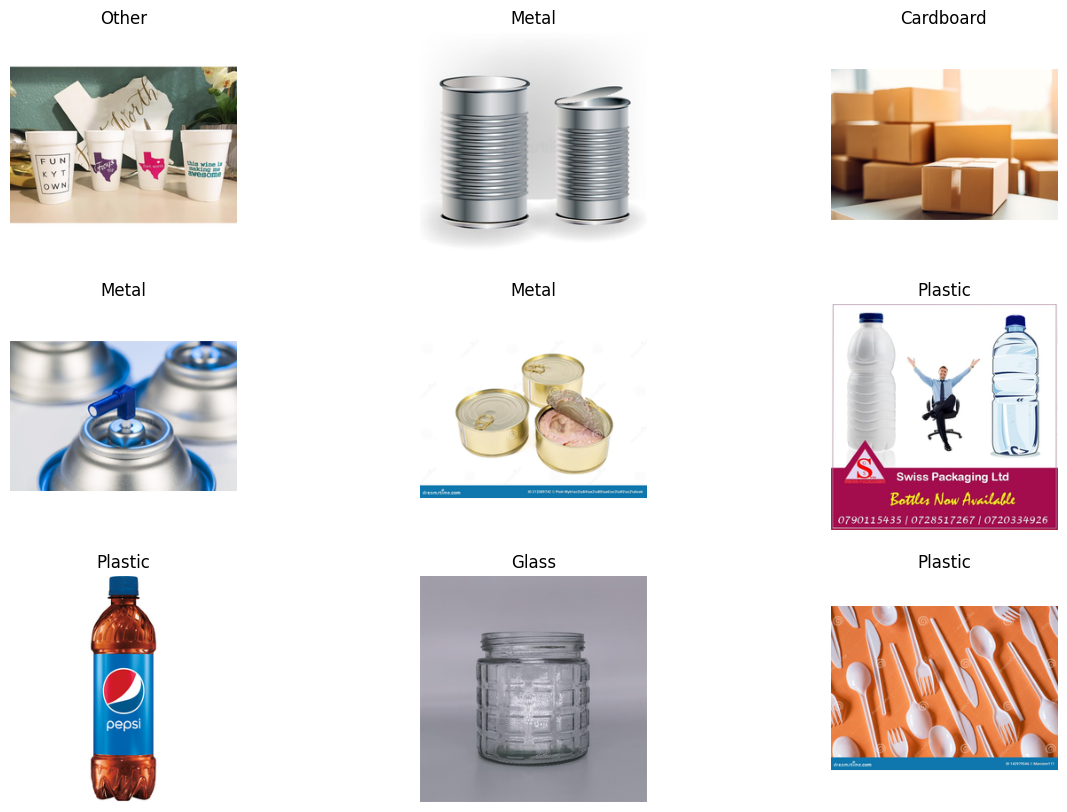

In [22]:
# Visualise Sample Images (across different labels)

plt.figure(figsize=(15, 10))
for i in range(9):
    idx = random.randint(0, len(train_images)-1)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(train_images[idx].astype("uint8"))
    plt.title(tf_train_dataset.class_names[train_labels[idx]])
    plt.axis("off")

#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [23]:
# Find the smallest and largest image dimensions from the data set

print(f"smallest width = {min_widths_list}")
print(f"largest width = {max_widths_list}")
print(f"smallest height = {min_heights_list}")
print(f"largest height = {max_heights_list}")

smallest width = 256
largest width = 256
smallest height = 256
largest height = 256


In [24]:
# Resize the image dimensions

# Since all the images are of 256 X 256 dimension, not resizing the images unless it is required based on further analysis

### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [25]:
# Encode the labels suitably

# As part of keras `image_dataset_from_directory`, the labels are encoded to integers

### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [26]:
# Assign specified parts of the dataset to train and validation sets

# The data is already split into train and validation in the 80:20 ratio as part of image_dataset_from_directory
print(f"train dataset shape is {train_images.shape}")
print(f"validation dataset shape is {val_images.shape}")

print(f"train labels shape is {train_labels.shape}")
print(f"validation labels shape is {val_labels.shape}")

train dataset shape is (6100, 256, 256, 3)
validation dataset shape is (1525, 256, 256, 3)
train labels shape is (6100,)
validation labels shape is (1525,)


In [28]:
# Normalise the train and validation dataset
train_images_normalised = train_images.astype(np.float64) / 255.0
val_images_normalised = val_images.astype(np.float64) / 255.0

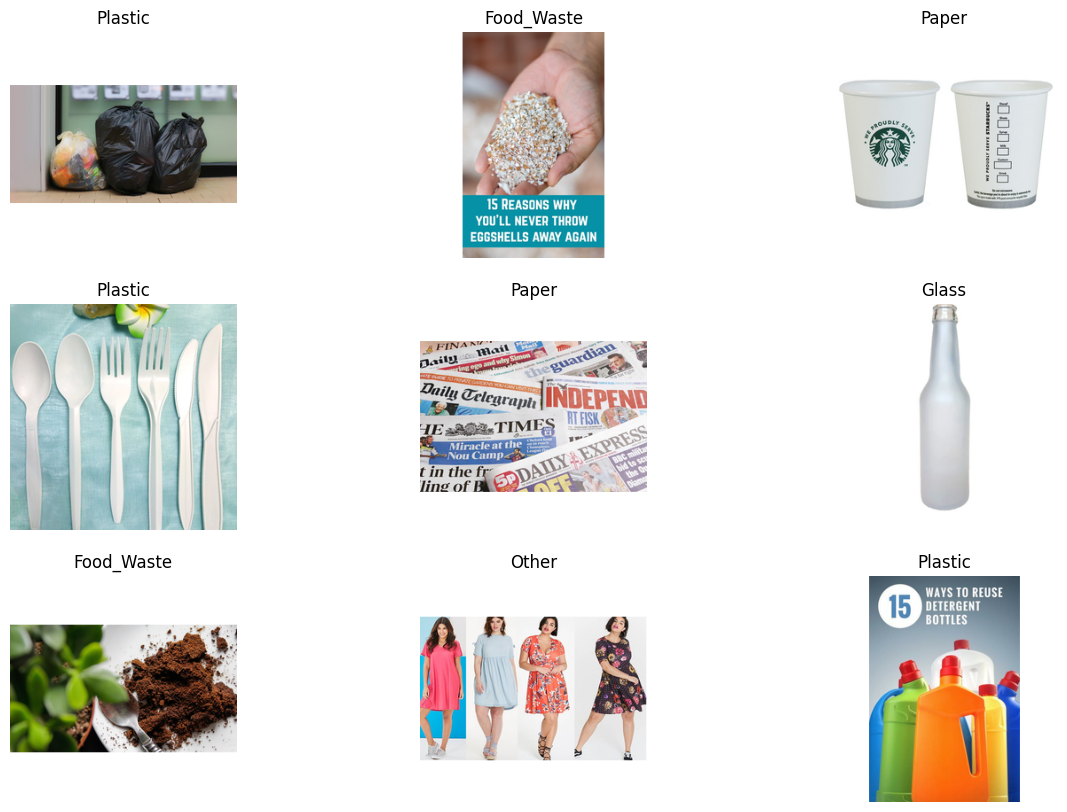

In [29]:
# Check if the Sample Images (across different labels) still looks right
plt.figure(figsize=(15, 10))
for i in range(9):
    idx = random.randint(0, len(train_images)-1)
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(train_images_normalised[idx].astype("float64"))
    plt.title(tf_train_dataset.class_names[train_labels[idx]])
    plt.axis("off")

## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

In [30]:
batch_size = 32
num_classes = 7
epochs = 10


In [33]:
# Build and compile the model
X_train = train_images_normalised
y_train = train_labels

X_test = val_images_normalised
y_test = val_labels

# model architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(tf_train_dataset.class_names)))
model.add(Activation('softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [34]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 254, 254, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 254, 254, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 127, 127, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 125, 125, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 62, 62, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 60, 60, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    58,982,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 7)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,273,511 (226.11 MB)

 Trainable params: 59,273,511 (226.11 MB)

 Non-trainable params: 0 (0.00 B)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [34]:
# Optimiser can be a hyper parameter

In [35]:
# Training
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [36]:
history = model.fit(train_images_normalised, train_labels, epochs=10, validation_data=(val_images_normalised, val_labels))

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 34s 110ms/step - accuracy: 0.2901 - loss: 2.3088 - val_accuracy: 0.2957 - val_loss: 1.7709
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3587 - loss: 1.7012 - val_accuracy: 0.3685 - val_loss: 1.6379
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.3985 - loss: 1.5750 - val_accuracy: 0.4033 - val_loss: 1.5562
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4330 - loss: 1.4714 - val_accuracy: 0.4079 - val_loss: 1.5319
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.4920 - loss: 1.3198 - val_accuracy: 0.4610 - val_loss: 1.4767
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.5838 - loss: 1.1192 - val_accuracy: 0.4826 - val_loss: 1.4465
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.6807 - loss: 0.9057 - val_accuracy: 0.5115 - val_loss: 1.5227
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.7615 - loss: 0.6688 - val_ac

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [37]:
# Evaluate on the test set; display suitable metrics



In [37]:
test_loss, test_acc = model.evaluate(val_images_normalised, val_labels, verbose=2)
print(f"Test accuracy: {test_acc}, Test loss: {test_loss}")

48/48 - 1s - 13ms/step - accuracy: 0.5580 - loss: 1.6630
Test accuracy: 0.5580328106880188, Test loss: 1.6629678010940552


In [38]:
# Second attempt with Batch Normalisation added and l2 regulariser.



X_train = train_images_normalised
y_train = train_labels

X_test = val_images_normalised
y_test = val_labels

# model architecture
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(64, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Conv2D(128, (3, 3), padding='same'))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))

model1.add(Flatten())
model1.add(Dense(512, kernel_regularizer=l2(0.01)))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(len(tf_train_dataset.class_names)))
model1.add(Activation('softmax'))

In [40]:
# Training
model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history1 = model1.fit(train_images_normalised, train_labels, epochs=10, validation_data=(val_images_normalised, val_labels))
test1_loss, test1_acc = model1.evaluate(val_images_normalised, val_labels, verbose=2)
print(f"Test accuracy: {test1_acc}, Test loss: {test1_loss}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - accuracy: 0.2383 - loss: 51.5087 - val_accuracy: 0.1449 - val_loss: 40.3886
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.2694 - loss: 15.9500 - val_accuracy: 0.2610 - val_loss: 8.7712
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2957 - loss: 5.9082 - val_accuracy: 0.2925 - val_loss: 3.9626
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3108 - loss: 3.7673 - val_accuracy: 0.2925 - val_loss: 4.8415
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3349 - loss: 3.5955 - val_accuracy: 0.3351 - val_loss: 4.4564
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3246 - loss: 4.5203 - val_accuracy: 0.2892 - val_loss: 3.9022
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3535 - loss: 3.3721 - val_accuracy: 0.3397 - val_loss: 3.8028
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3626 - loss: 3.6963 - val_

In [41]:
# Removed lr from previous step
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=X_train.shape[1:]))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(128, (3, 3), padding='same'))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(512))
model2.add(Activation('relu'))
model2.add(Dropout(0.5))
model2.add(Dense(len(tf_train_dataset.class_names)))
model2.add(Activation('softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history2 = model2.fit(train_images_normalised, train_labels, epochs=10, validation_data=(val_images_normalised, val_labels))
test2_loss, test2_acc = model2.evaluate(val_images_normalised, val_labels, verbose=2)
print(f"Test accuracy: {test2_acc}, Test loss: {test2_loss}")

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 23s 79ms/step - accuracy: 0.2417 - loss: 32.6566 - val_accuracy: 0.1502 - val_loss: 32.3576
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2982 - loss: 1.9142 - val_accuracy: 0.2400 - val_loss: 14.7544
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.2988 - loss: 1.9642 - val_accuracy: 0.1836 - val_loss: 4.5827
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3000 - loss: 1.8798 - val_accuracy: 0.2748 - val_loss: 2.0031
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3036 - loss: 1.8375 - val_accuracy: 0.2957 - val_loss: 1.9895
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3039 - loss: 1.8156 - val_accuracy: 0.3082 - val_loss: 1.7952
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3101 - loss: 1.7959 - val_accuracy: 0.3121 - val_loss: 1.8148
Epoch 8/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - accuracy: 0.3286 - loss: 1.7712 - val_

## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images



Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images




In [ ]:
# Create the augmented training dataset



##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images



## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
* Report model training results

# Finding abouts data

*   There are 7625 items out of which Plastic category has the more images. We could try to treat class imbalance provided we have additional runtime available.
*   All images are 256 X 256 size. Hence no reshaping was done. Only rescaled to ensure all the values are between 0-1

# Model training results

*   Three different configs were run (3 convolutional layers and 1 Dense layer is common for all three)
  *   Without Batch Normalisation and lr - Test accuracy: 0.5580328106880188
  *   With Batch Normalisation and lr - Test accuracy: 0.3186885118484497
  *   With Batch Normalisation and not lr - Test accuracy: 0.3186885118484497

Overall the model performed better without BatchNormalisation and lr. But still there is scope to perform morphological transformation of images, running different hyper parameter to improve the model accuracy provided we have proper GPU runtime hardware available to experiment.
